We aim to highlight a pink effect on Vinted plateform. It means that we are investigating to see if women pay higher prices than men for similar prodcuts in average. 
With the collected data, we try to analyse if gender has a real impact on prices while taking into account other parameters like the brand, the quality of product, the catagory of product. 

Here is the code to analyse the data obtained through the scrapping of Vinted API. 

We will see that some imporvements could be to made to this scrapping algorithms to gather missing data like the quality of products or the rating of the seller. 

In [2]:
import time
import requests
import pandas as pd
import random
import json
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
#Here we create a dictionary to map category IDs to genders

gender_dict = {
    # HOMME — vêtements
    "32": "homme",
    "1206": "homme",
    "34": "homme",
    "85": "homme",
    "84": "homme",
    "92": "homme",
    "257": "homme",
    "76": "homme",
    "79": "homme",
    "80": "homme",
    "2910": "homme",
    "30": "homme",

    # HOMME — chaussures
    "1233": "homme",
    "2657": "homme",
    "1238": "homme",
    "2659": "homme",
    "1242": "homme",
    "2656": "homme",
    "2970": "homme",
    "2969": "homme",
    "2968": "homme",
    "1452": "homme",

    # FEMME — vêtements
    "13": "femme",
    "10": "femme",
    "12": "femme",
    "9": "femme",
    "1035": "femme",
    "29": "femme",
    "73": "femme",
    "1037": "femme",
    "8": "femme",
    "11": "femme",
    "183": "femme",
    "15": "femme",
    "28": "femme",
    "1176": "femme",
    "1782": "femme",

    # FEMME — chaussures
    "2954": "femme",
    "2623": "femme",
    "2955": "femme",
    "1049": "femme",
    "2953": "femme",
    "543": "femme",
    "2950": "femme",
    "215": "femme",
    "2632": "femme",
    "2952": "femme",
    "2951": "femme",
    "2949": "femme",
    "2630": "femme",
}


In [4]:
#Here we create a dictionary to map category IDs to super categories that can be considered similar for men and women 

category_dict = {
    # HOMME — vêtements
    "32": "suits and blazers",
    "1206": "outerwear",
    "34": "trousers",
    "85": "socks and underwear",
    "84": "swimwear",
    "92": "costumes and special outfits",
    "257": "jeans",
    "76": "tops and t-shirts",
    "79": "jumpers and sweaters",
    "80": "shorts",
    "2910": "sleepwear",
    "30": "activewear",

    # HOMME — chaussures
    "1233": "boots",
    "2657": "espadrilles",
    "1238": "formal shoes",
    "2659": "slippers",
    "1242": "trainers",
    "2656": "boat shoes, loafers and moccasins",
    "2970": "clogs and mules",
    "2969": "flip-flops and slides",
    "2968": "sandals",
    "1452": "sports shoes",

    # FEMME — vêtements
    "13": "jumpers and sweaters",
    "10": "dresses",
    "12": "tops and t-shirts",
    "9": "trousers and leggings",
    "1035": "jumpsuits and playsuits",
    "29": "lingerie and nightwear",
    "73": "activewear",
    "1037": "outerwear",
    "8": "suits and blazers",
    "11": "skirts",
    "183": "jeans",
    "15": "shorts and cropped trousers",
    "28": "swimwear",
    "1176": "maternity clothes",
    "1782": "costumes and special outfits",

    # FEMME — chaussures
    "2954": "boat shoes, loafers and moccasins",
    "2623": "clogs and mules",
    "2955": "ballerinas",
    "1049": "boots",
    "2953": "espadrilles",
    "543": "heels",
    "2950": "mary janes and t-bar shoes",
    "215": "slippers",
    "2632": "trainers",
    "2952": "flip-flops and slides",
    "2951": "lace-up shoes",
    "2949": "sandals",
    "2630": "sports shoes",
}


In [5]:
#Here we create a dictionary to map category titles to super categories that can be considered similar for men and women
super_category_dict = {
    # Pants / trousers / leggings
    "trousers": "trousers",
    "trousers and leggings": "trousers",
    "jeans": "jeans",
    "shorts": "shorts",
    "shorts and cropped trousers": "shorts",

    # Tops / T-shirts / jumpers
    "tops and t-shirts": "t-shirts",
    "jumpers and sweaters": "jumpers",
    "sweatshirts": "jumpers",
    
    # Dresses / skirts
    "dresses": "dresses",
    "skirts": "skirts",
    "jumpsuits and playsuits": "jumpsuits",

    # Outerwear
    "outerwear": "outerwear",
    
    # Suits / blazers
    "suits and blazers": "suits and blazers",
    
    # Swimwear / lingerie / activewear
    "swimwear": "swimwear",
    "lingerie and nightwear": "lingerie",
    "activewear": "activewear",
    "sleepwear": "sleepwear",
    "maternity clothes": "maternity clothes",
    "costumes and special outfits": "special outfits",
    
    # Shoes (all types merged)
    "boots": "shoes",
    "espadrilles": "shoes",
    "formal shoes": "shoes",
    "slippers": "shoes",
    "trainers": "shoes",
    "boat shoes, loafers and moccasins": "shoes",
    "clogs and mules": "shoes",
    "flip-flops and slides": "shoes",
    "sandals": "shoes",
    "sports shoes": "shoes",
    "ballerinas": "shoes",
    "heels": "shoes",
    "mary janes and t-bar shoes": "shoes",
    "lace-up shoes": "shoes"
}


In [6]:
#This script converts the raw JSONL data obtained from Vinted scraping into a cleaned JSON file with selected fields.

#The input_path path may need to be changed to your local paths obtained with the scrapping
input_path = r"vinted_products_api.jsonl"
output_path = r"vinted_clean.json" 

converted_items = []

with open(input_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue  # skip empty lines
        try:
            item = json.loads(line)
        except json.JSONDecodeError as e:
            print(f"Skipping line {i} due to JSON error: {e}")
            continue

        query = str(item.get("query")) if item.get("query") is not None else None #the query gives us the category ID

#Here is the description of the data that we collected or inferred from the raw data
        converted_item = {
            "item_id": item.get("id"),
            "price": float(item["prix"]["amount"]) if item.get("prix") else None,
            "currency": item["prix"]["currency_code"] if item.get("prix") else None,
            "gender": gender_dict.get(query),
            "category_title": category_dict.get(query),
            "category_id": query,
            "brand": item.get("marque"),
            "title": item.get("titre"),
            "url": item.get("url"),
            "user_id": item.get("vendeur_id"),
            "username": item.get("vendeur_nom"),
            "country": item.get("country")
        }

        converted_items.append(converted_item)

# Save as JSON array
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(converted_items, f, ensure_ascii=False, indent=4)



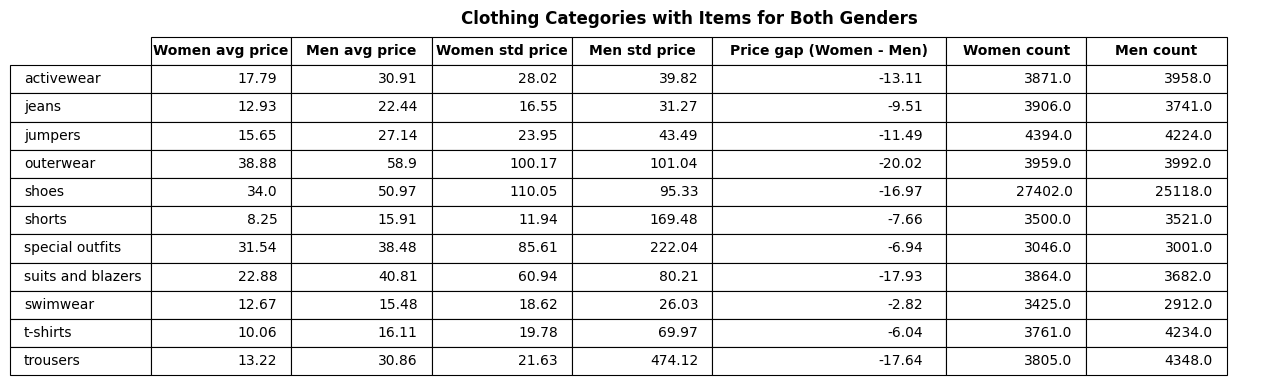

In [7]:
# This script analyzes the cleaned Vinted data to compare average prices, standard deviation, and number of items collected for both genders.

df = pd.read_json(output_path)

df["super_category"] = df["category_title"].map(super_category_dict)
df = df.dropna(subset=["super_category"])

category_col = "super_category"
gender_col = "gender"
price_col = "price"

# ---- Average price by clothing type and gender ----
avg_price = (
    df.groupby([category_col, gender_col])[price_col]
    .mean()
    .unstack()
    .reindex(columns=["femme", "homme"])
)

# ---- Standard deviation by clothing type and gender ----
std_price = (
    df.groupby([category_col, gender_col])[price_col]
    .std()
    .unstack()
    .reindex(columns=["femme", "homme"])
)

# ---- Number of items by clothing type and gender ----
counts = (
    df.groupby([category_col, gender_col])[price_col]
    .count()
    .unstack()
    .reindex(columns=["femme", "homme"])
)

# ---- Merge all metrics ----
summary = avg_price.join(
    counts, lsuffix="_avg", rsuffix="_count"
).join(
    std_price, rsuffix="_std"
)

# ---- Rename columns clearly ----
summary.columns = [
    "Women avg price", "Men avg price",
    "Women count", "Men count",
    "Women std price", "Men std price"
]

# ---- Price gap ----
summary["Price gap (Women - Men)"] = summary["Women avg price"] - summary["Men avg price"]

# ---- Filter only categories with both men and women items ----
summary = summary[(summary["Women count"] > 0) & (summary["Men count"] > 0)]

# ---- Round for presentation ----
summary = summary.round(2)

# ---- Reorder columns ----
summary = summary[
    [
        "Women avg price",
        "Men avg price",
        "Women std price",
        "Men std price",
        "Price gap (Women - Men)",
        "Women count",
        "Men count"
    ]
]

# ---- Render academic black & white table ----
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13, 4))  # slightly wider for std columns
ax.axis("off")

col_widths = [0.12, 0.12, 0.12, 0.12, 0.20, 0.12, 0.12]

table = ax.table(
    cellText=summary.values,
    colLabels=summary.columns,
    rowLabels=summary.index,
    colWidths=col_widths,
    loc="center"
)

# ---- Styling (academic) ----
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor("black")
    cell.set_linewidth(0.8)
    if row == 0:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("white")

plt.title(
    "Clothing Categories with Items for Both Genders",
    fontsize=12,
    weight="bold"
)

plt.tight_layout()
plt.show()


These results are very surprising. Indeed the price is in the other direction compared to what we expected. For every category, men pay a higher price in average. We can observe that the number of items collected is relatively significant for each category. 

It seems that we are more in the presence of a blue effect rather than a pink effect. However categories are very large with broad range of items as it is shown by the fact that standard deviations are of the same rough size as average prices. It is likely that the presence of very high priced luxury items is influencing the results. So perhaps a more precise study on brands, quality or other factors might nuance these results. 

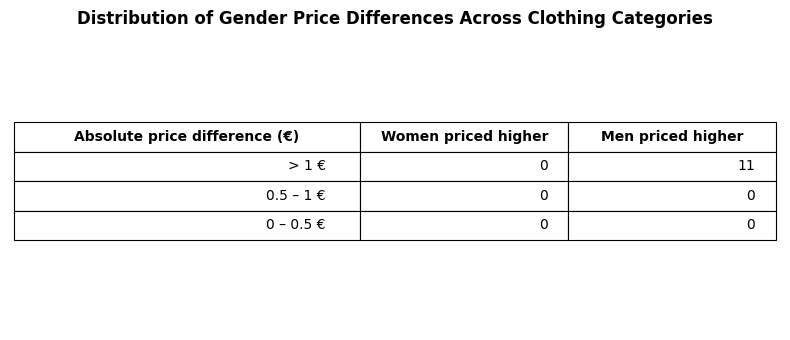

In [8]:
#This script analyzes the cleaned Vinted data to summarize the distribution of price differences between men and women across clothing categories.
df = pd.read_json(output_path)

df["super_category"] = df["category_title"].map(super_category_dict)
df = df.dropna(subset=["super_category"])

category_col = "super_category"
gender_col = "gender"
price_col = "price"


avg_price = (
    df.groupby([category_col, gender_col])[price_col]
    .mean()
    .unstack()
)

#Price gap 
avg_price["gap"] = avg_price["femme"] - avg_price["homme"]

# Drop categories missing one gender
avg_price = avg_price.dropna(subset=["gap"])

bins = [
    (1.0, float("inf"), "> 1 €"),
    (0.5, 1.0, "0.5 – 1 €"),
    (0.0, 0.5, "0 – 0.5 €")
]

rows = []

for low, high, label in bins:
    women_higher = ((avg_price["gap"] > low) & (avg_price["gap"] <= high)).sum()
    men_higher = ((avg_price["gap"] < -low) & (avg_price["gap"] >= -high)).sum()
    
    rows.append([label, women_higher, men_higher])

summary_table = pd.DataFrame(
    rows,
    columns=[
        "Absolute price difference (€)",
        "Women priced higher",
        "Men priced higher"
    ]
)

#Render academic black & white table
fig, ax = plt.subplots(figsize=(8, 3.5))
ax.axis("off")

table = ax.table(
    cellText=summary_table.values,
    colLabels=summary_table.columns,
    loc="center",
    colWidths=[0.45, 0.27, 0.27]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.6)

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor("black")
    cell.set_linewidth(0.8)
    if row == 0:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("white")

plt.title(
    "Distribution of Gender Price Differences Across Clothing Categories",
    fontsize=12,
    weight="bold"
)

plt.tight_layout()
plt.show()

The conclusion is obvisouly the same as for the last tables. However, it is interesting to notice that the price gap is always higher than 1 euros so it is significant. Maybe this threshold should be changed for a percentage of the average price of products in each category to be more significant. 

In [9]:
#This script prepares the cleaned Vinted data for visualization of price distributions by gender

with open(output_path, "r", encoding="utf-8") as f:
    items = json.load(f)

df = pd.DataFrame(items)

#Drop rows with missing price or gender
df = df.dropna(subset=["price", "gender"])

df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna(subset=["price"])

#Map gender to markers for plotting
marker_map = {"femme": "o", "homme": "s"}  # circle for women, square for men
df["marker"] = df["gender"].map(marker_map)

In [10]:
#This script defines a function to create academic-style boxplots with individual data points overlaid
def academic_boxplot(data, x, y, hue, title, xlabel, ylabel, categories=None):
    plt.figure(figsize=(7,5))

    # Boxplot without colors
    sns.boxplot(x=x, y=y, data=data, showcaps=True, boxprops=dict(facecolor='white', edgecolor='black'),
                whiskerprops=dict(color='black'), capprops=dict(color='black'), medianprops=dict(color='black'))

    # Overlay individual points with markers per gender
    for gender in data[hue].unique():
        subset = data[data[hue] == gender]
        plt.scatter(
            x=subset[x].values,
            y=subset[y].values,
            alpha=0.7,
            marker=marker_map.get(gender, 'o'),
            label=gender,
            edgecolor='black',
            facecolor='white',
            s=50
        )
    plt.title(title, fontsize=12, weight='bold')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if categories:
        plt.xticks(range(len(categories)), categories)
    plt.legend(title=hue, loc='best')
    plt.tight_layout()
    plt.show()

In [11]:
#This script defines a function to create academic-style summary plots with means and confidence intervals
def academic_summary_plot(data, x, y, hue, title, xlabel, ylabel, categories=None):

    plt.figure(figsize=(10,5))

    # Determine categories
    if categories is None:
        categories = sorted(data[x].unique())
    category_indices = np.arange(len(categories))

    # Explicit gender order
    gender_order = ["femme", "homme"]

    # Compute averages and CI
    plot_data = []
    for i, cat in enumerate(categories):
        for gender in gender_order:
            subset = data[(data[x] == cat) & (data[hue] == gender)]
            if subset.empty:
                continue
            mean = subset[y].mean()
            se = subset[y].std() / np.sqrt(len(subset))
            ci_lower = mean - 1.96 * se
            ci_upper = mean + 1.96 * se
            # **No horizontal offset** → symbol is centered over tick
            plot_data.append({
                "x_pos": i,
                "mean": mean,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper,
                "gender": gender
            })

    plot_df = pd.DataFrame(plot_data)

    # Plot averages with CI
    first = True
    for gender in gender_order:
        subset = plot_df[plot_df["gender"] == gender]
        if subset.empty:
            continue
        plt.errorbar(
            x=subset["x_pos"],
            y=subset["mean"],
            yerr=[subset["mean"] - subset["ci_lower"], subset["ci_upper"] - subset["mean"]],
            fmt='x',
            markersize=7,
            capsize=5,
            linestyle='None',
            color='black',
            label='Average price ± 95% CI' if first else None
        )
        first = False

    # X-axis labels
    plt.xticks(category_indices, categories, rotation=45, ha='right')

    # Labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=12, weight='bold')

    # Single legend
    plt.legend()
    plt.tight_layout()
    plt.show()







C:\Users\quent\AppData\Roaming\Python\Python313\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


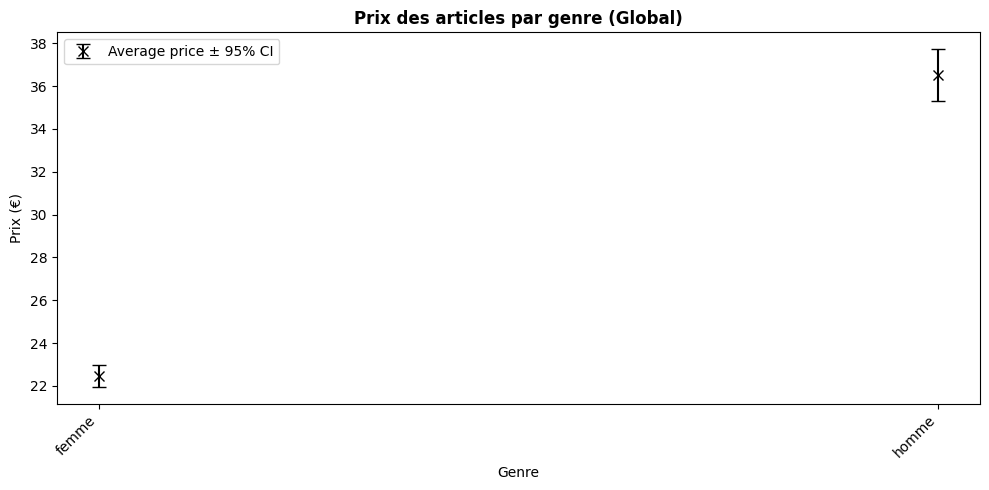

In [12]:

#Call the academic_summary_plot with the filtered data
academic_summary_plot(
    data=df[df["price"] <= 30000],
    x="gender",
    y="price",
    hue="gender",
    title="Prix des articles par genre (Global)",
    xlabel="Genre",
    ylabel="Prix (€)"
)


We can observe that the average price paid by a man for a product on Vinted in the observed categories is significantly higher than the price paid by a woman. We can also observe that the confidence intervals are relatively narrow therefore the prices seem to be concentrated close to these rough sizes. 

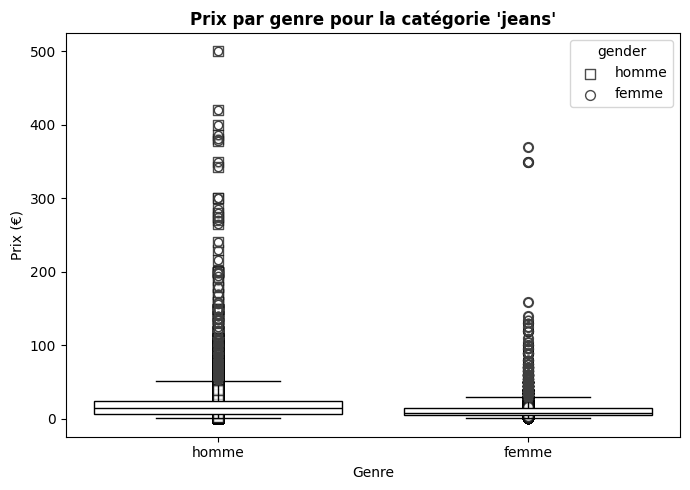

In [13]:
#This script allows to compare price distributions by gender for specific clothing categories 
categories_to_compare = ["jeans"]
df["super_category"] = df["category_title"].map(super_category_dict)
df = df.dropna(subset=["super_category"])
for cat in categories_to_compare:
    df_cat = df[df["super_category"].str.lower() == cat]
    if df_cat.empty:
        continue
    academic_boxplot(
        df_cat,
        x="gender",
        y="price",
        hue="gender",
        title=f"Prix par genre pour la catégorie '{cat}'",
        xlabel="Genre",
        ylabel="Prix (€)"
    )

We can observe that the average price paid by men is slightly higher in the category jeans. It seems that there are many more men items with very high prices (above 100) so one hypothesis could be that there are more high quality and therefore high priced products in proportion for men. 

In [14]:
#This script visualizes average prices by item condition and gender 
#However, the condition data is missing from the dataset and therefore the scrapping will need to be adapted to treat this problematic.
# etat_field = 'condition'  

# avg_price_by_gender = df.groupby([etat_field, 'gender'])['price'].mean().unstack()

# print(avg_price_by_gender)

# fig, ax = plt.subplots(figsize=(12, 6))

# bar_width = 0.35
# states = avg_price_by_gender.index
# x = range(len(states))

# ax.bar([i - bar_width/2 for i in x], avg_price_by_gender['homme'], 
#        width=bar_width, color='black', label='Hommes', hatch='//')

# ax.bar([i + bar_width/2 for i in x], avg_price_by_gender['femme'], 
#        width=bar_width, color='white', edgecolor='black', label='Femmes', hatch='\\\\')

# ax.set_xticks(x)
# ax.set_xticklabels(states, rotation=45, ha='right')
# ax.set_ylabel("Prix moyen")
# ax.set_xlabel("État de l'article")
# ax.set_title("Prix moyen par état et par genre")

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(axis='y', linestyle='--', alpha=0.5)

# ax.legend(frameon=False)

# plt.tight_layout()
# plt.show()

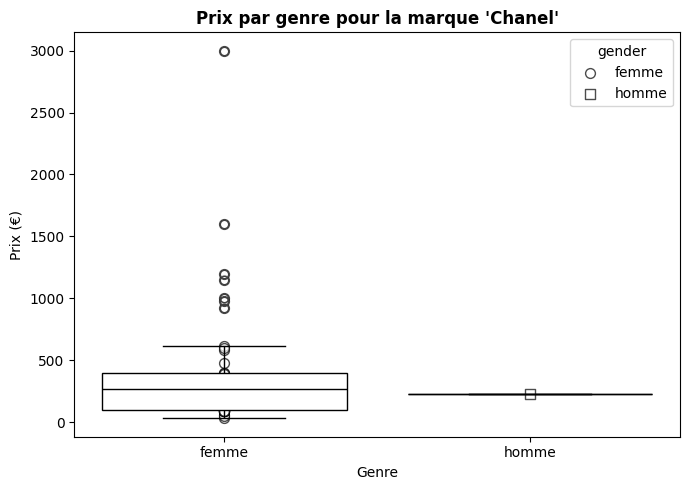

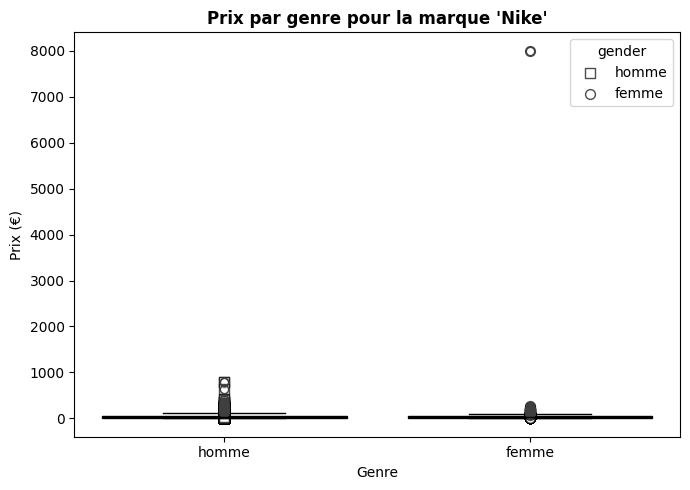

In [15]:
#This script visualizes price distributions by gender for specific brands 
brands_to_compare = ["Chanel", "Nike"]
for brand in brands_to_compare:
    df_brand = df[df["brand"].str.lower() == brand.lower()]
    if df_brand.empty:
        continue
    academic_boxplot(
        df_brand,
        x="gender",
        y="price",
        hue="gender",
        title=f"Prix par genre pour la marque '{brand}'",
        xlabel="Genre",
        ylabel="Prix (€)"
    )

It is interesting to compare smaller dataset. Indeed, in a clothing category people can find numerous products with very different caracteristics (brand, quality, ...). Normally, every product of a brand has the same level of reputation or prestige and adress the same kinf of customer (affordable, luxury, ...). We can see that here the results are more nuanced. For Nike that sell the same kind of products to men and women, shoes, the average price paid by women is higher than the average price paid by men. Therefore it could be interesting to investigate more in this direction and analyze smaller more precise dataset. 

In [16]:
#This script performs a regression analysis to examine the relationship between item prices and gender

df = pd.read_json(output_path)

df = df.dropna(subset=["price", "gender", "brand", "country"])

for col in ["brand", "country", "gender"]:
    df[col] = df[col].apply(lambda x: ", ".join(x) if isinstance(x, list) else x)

df = df[df["price"] > 0]

#Regression
# Dependent variable: price
# Control: gender
formula = "price ~ C(gender)"

# Fit the model
model = smf.ols(formula, data=df).fit()

results_table = pd.DataFrame({
    'Variable': model.params.index,
    'Coefficient': model.params.values,
    'Std. Error': model.bse.values,
    'p-value': model.pvalues.values
})

notes = f"Dependent variable: log_price\nNumber of observations: {int(model.nobs)}"

fit_measures = pd.DataFrame({
    'Measure': ['R-squared', 'Adj. R-squared'],
    'Value': [model.rsquared, model.rsquared_adj]
})

print("Regression results:\n")
print(results_table.to_string(index=False))
print("\nNotes:")
print(notes)
print("\nFit measures:")
print(fit_measures.to_string(index=False))


Regression results:

          Variable  Coefficient  Std. Error      p-value
         Intercept    22.462784    0.502724 0.000000e+00
C(gender)[T.homme]    14.493947    0.749319 2.947794e-83

Notes:
Dependent variable: log_price
Number of observations: 152951

Fit measures:
       Measure    Value
     R-squared 0.002440
Adj. R-squared 0.002434


Firstly, the average influence of the gender variable men is around 14.7 euros which is very significant. Moreover, the p-value is very close to zero and the hypothesis that the variable men don't influence the price can be rejected at a 1% level which is very significant. 
However, the R-Squared value is very low and tehrefore seems to indicate that the variable men only explains a small part of the price variations. We should therefore investigate other variables like brands, countrys, quality and add them to the control variables. 

In [17]:
from collections import defaultdict

query_stats = defaultdict(lambda: {
    'count': 0,
    'total_price': 0,
    'prices': [],
    'genders': set(),
    'categories': set(),
    'countries': set()
})

types_currency = []
nb_item_other_currency = 0
countries = [ "co.uk", "sk", "si", "ro", "lv", "lt", "hu", "de", "fr", "pt", "es", "com", "it", "nl", "be", "at", "pl", "cz", "lu", "dk", "ee", "se", "gr", "ie", "hr"]


with open('vinted_products_api.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        item = json.loads(line)
        
        # Filtrer uniquement les articles en EUR
        curr_type = item.get('prix', {}).get('currency_code')
        if curr_type != 'EUR':
            types_currency.append(curr_type)
            nb_item_other_currency += 1
            continue
            
        query = item['query']
        price = float(item['prix']['amount'])
        gender = gender_dict.get(query, 'unknown')
        category = category_dict.get(query, 'unknown')
        country = item.get('country', 'unknown')

        query_stats[query]['count'] += 1
        query_stats[query]['total_price'] += price
        query_stats[query]['prices'].append(price)
        query_stats[query]['genders'].add(gender)
        query_stats[query]['categories'].add(category)

# Create summary DataFrame
summary_data = []
for query, stats in query_stats.items():
    if stats['count'] == 0:  # Skip empty categories
        continue
    prices = stats['prices']
    summary_data.append({
        'Query (Category ID)': query,
        'Gender': ', '.join(stats['genders']),
        'Category': ', '.join(stats['categories']),
        'Number of Items': stats['count'],
        'Average Price (€)': round(stats['total_price'] / stats['count'], 2),
        'Min Price (€)': min(prices),
        'Max Price (€)': max(prices),
        'Median Price (€)': round(pd.Series(prices).median(), 2)
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values(['Category', 'Gender'], ascending=False)

# Display the summary table
print("Summary Table of Vinted Data by Category (Query) - EUR only")
print("=" * 85)
print(df_summary.to_string(index=False))

print("\nCurrency types encountered (non-EUR):", set(types_currency))
print("Number of items in non-EUR currencies:", nb_item_other_currency)

Summary Table of Vinted Data by Category (Query) - EUR only
Query (Category ID) Gender                          Category  Number of Items  Average Price (€)  Min Price (€)  Max Price (€)  Median Price (€)
                  9  femme             trousers and leggings             3145              13.64           1.00         499.99              8.00
                 34  homme                          trousers             3609              32.17           1.00       31223.45             15.00
               1242  homme                          trainers             3004              66.10           1.00        1036.16             50.00
               2632  femme                          trainers             1935              44.68           1.00         675.00             32.00
                 76  homme                 tops and t-shirts             3499              15.57           1.00        4313.30             10.00
                 12  femme                 tops and t-shirts          

In [18]:
# Tri par pays et catégorie

with open('vinted_products_api.jsonl', 'r', encoding='utf-8') as f:
        query_stats = defaultdict(lambda: defaultdict(lambda: {
                'count': 0,
                'total_price': 0,
                'prices': [],
                'genders': set(),
                'categories': set(),
            }))

        for line in f:
            item = json.loads(line)
            # Filtrer uniquement les articles en EUR
            curr_type = item.get('prix', {}).get('currency_code')
            country = item.get('country', 'unknown')
            if country == ['fr']:
                country = 'fr'
            if curr_type != 'EUR' and country != 'co.uk':
                types_currency.append(curr_type)
                nb_item_other_currency += 1
                continue
            
            
            query = item['query']
            price = float(item['prix']['amount'])
            gender = gender_dict.get(query, 'unknown')
            category = category_dict.get(query, 'unknown')

            query_stats[country][query]['count'] += 1
            query_stats[country][query]['total_price'] += price
            query_stats[country][query]['prices'].append(price)
            query_stats[country][query]['genders'].add(gender)
            query_stats[country][query]['categories'].add(category)

for country in countries:          
    # Create summary DataFrame
    summary_data = []
    for query, stats in query_stats[country].items():
        if stats['count'] == 0:  # Skip empty categories
            continue
        prices = stats['prices']
        if country == 'co.uk':
            summary_data.append({
                'Query (Category ID)': query,
                'Gender': ', '.join(stats['genders']),
                'Category': ', '.join(stats['categories']),
                'Number of Items': stats['count'],
                'Average Price (£)': round(stats['total_price'] / stats['count'], 2),
                'Min Price (£)': min(prices),
                'Max Price (£)': max(prices),
                'Median Price (£)': round(pd.Series(prices).median(), 2)
            })
        else:
            summary_data.append({
                'Query (Category ID)': query,
                'Gender': ', '.join(stats['genders']),
                'Category': ', '.join(stats['categories']),
                'Number of Items': stats['count'],
                'Average Price (€)': round(stats['total_price'] / stats['count'], 2),
                'Min Price (€)': min(prices),
                'Max Price (€)': max(prices),
                'Median Price (€)': round(pd.Series(prices).median(), 2)
            })
        
    if not summary_data:
        continue
    
    df_summary = pd.DataFrame(summary_data)
    df_summary = df_summary.sort_values('Category', ascending=False)

    # Display the summary table
    if country == 'co.uk':
        country = 'uk'
        print(f"Country {country} - Summary Table of Vinted Data by Category (Query) - GSB only")
    else:
        print(f"Country {country} - Summary Table of Vinted Data by Category (Query) - EUR only")
    print("=" * 85)
    print(df_summary.to_string(index=False))

Country uk - Summary Table of Vinted Data by Category (Query) - GSB only
Query (Category ID) Gender                          Category  Number of Items  Average Price (£)  Min Price (£)  Max Price (£)  Median Price (£)
                  9  femme             trousers and leggings              372              10.18           1.00          99.00              5.62
                 34  homme                          trousers              318              18.59           1.00         180.00             10.00
               2632  femme                          trainers              288              31.40           2.00         250.00             24.99
               1242  homme                          trainers              288              55.55           1.50         770.00             40.00
                 12  femme                 tops and t-shirts              288               8.02           1.00         295.00              4.50
                 76  homme                 tops and t-shi

C:\Users\quent\AppData\Local\Temp\ipykernel_7580\498986125.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


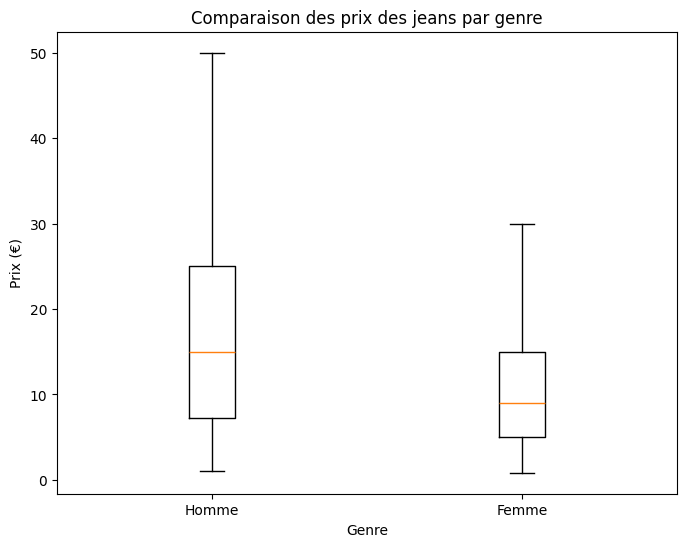

C:\Users\quent\AppData\Local\Temp\ipykernel_7580\498986125.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


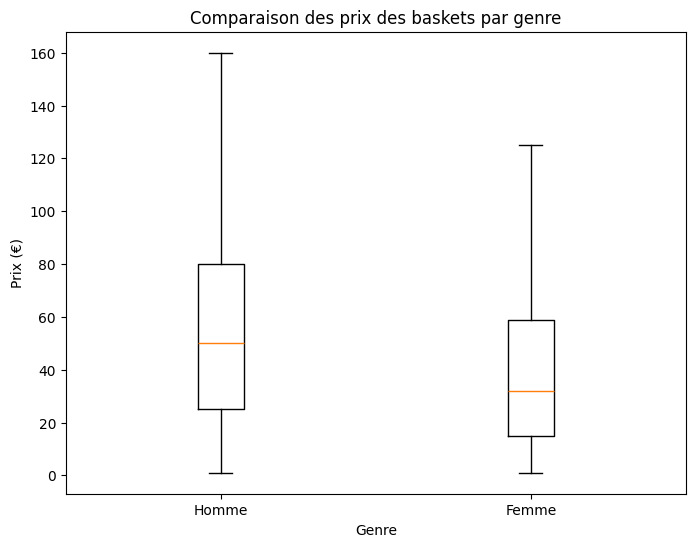

In [19]:
JEANS_QUERIES = {'257': 'Homme', '183': 'Femme'}
TRAINERS_QUERIES = {'1242': 'Homme', '2632': 'Femme'}
jeans_data = []
trainers_data = []

with open('vinted_products_api.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        item = json.loads(line)

        # Filtre devise
        if item.get('prix', {}).get('currency_code') != 'EUR':
            continue

        query = item.get('query')
        if query in JEANS_QUERIES:
            jeans_data.append({
                'price': float(item['prix']['amount']),
                'gender': JEANS_QUERIES[query],
                'country': item.get('country', 'unknown')
            })
        elif query in TRAINERS_QUERIES:
            trainers_data.append({
                'price': float(item['prix']['amount']),
                'gender': TRAINERS_QUERIES[query],
                'country': item.get('country', 'unknown')
            })
        else:
            continue  # uniquement jeans
        
    
    
df_jeans = pd.DataFrame(jeans_data)
df_trainers = pd.DataFrame(trainers_data)
# Boxplot for jeans
plt.figure(figsize=(8,6))
plt.boxplot(
    [
        df_jeans[df_jeans['gender'] == 'Homme']['price'],
        df_jeans[df_jeans['gender'] == 'Femme']['price']
    ],
    labels=['Homme', 'Femme'],
    showfliers=False
)
plt.xlabel('Genre')
plt.ylabel('Prix (€)')
plt.title('Comparaison des prix des jeans par genre')
plt.show()

# Boxplot for trainers
plt.figure(figsize=(8,6))
plt.boxplot(
    [df_trainers[df_trainers['gender'] == 'Homme']['price'],
        df_trainers[df_trainers['gender'] == 'Femme']['price']
    ],
    labels=['Homme', 'Femme'],
    showfliers=False
)
plt.xlabel('Genre')
plt.ylabel('Prix (€)')
plt.title('Comparaison des prix des baskets par genre')
plt.show()


C:\Users\quent\AppData\Local\Temp\ipykernel_7580\2355050044.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: remove_outliers_iqr(x, 'price'))


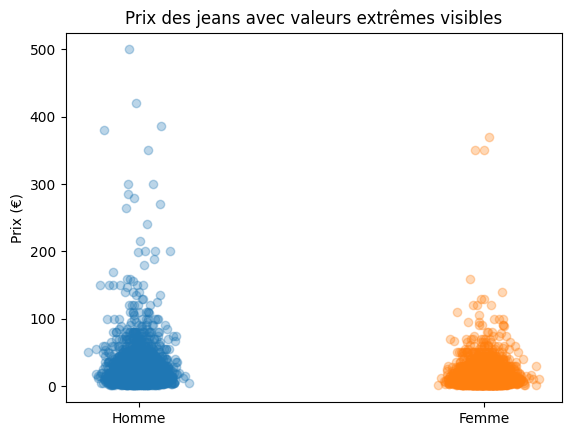

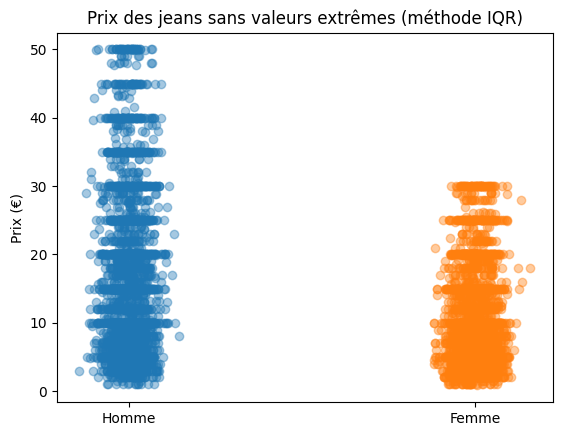

In [20]:
# Sans valeurs extrêmes

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

df_no_outliers = (
    df_jeans
    .groupby('gender', group_keys=False)
    .apply(lambda x: remove_outliers_iqr(x, 'price'))
)


for i, gender in enumerate(['Homme', 'Femme']):
    prices = df_jeans[df_jeans['gender'] == gender]['price']
    x = np.random.normal(i + 1, 0.04, size=len(prices))  # jitter
    plt.plot(x, prices, 'o', alpha=0.3)

plt.xticks([1, 2], ['Homme', 'Femme'])
plt.ylabel('Prix (€)')
plt.title('Prix des jeans avec valeurs extrêmes visibles')
plt.show()

for i, gender in enumerate(['Homme', 'Femme']):
    prices = df_no_outliers[df_no_outliers['gender'] == gender]['price']
    x = np.random.normal(i + 1, 0.04, size=len(prices))
    plt.plot(x, prices, 'o', alpha=0.4)

plt.xticks([1, 2], ['Homme', 'Femme'])
plt.ylabel('Prix (€)')
plt.title('Prix des jeans sans valeurs extrêmes (méthode IQR)')
plt.show()


   price gender  category country
0  34.99  homme  trousers      fr
1   9.00  homme  trousers      fr
2   5.00  homme  trousers      fr
3   4.00  homme  trousers      fr
4  24.99  homme  trousers      fr


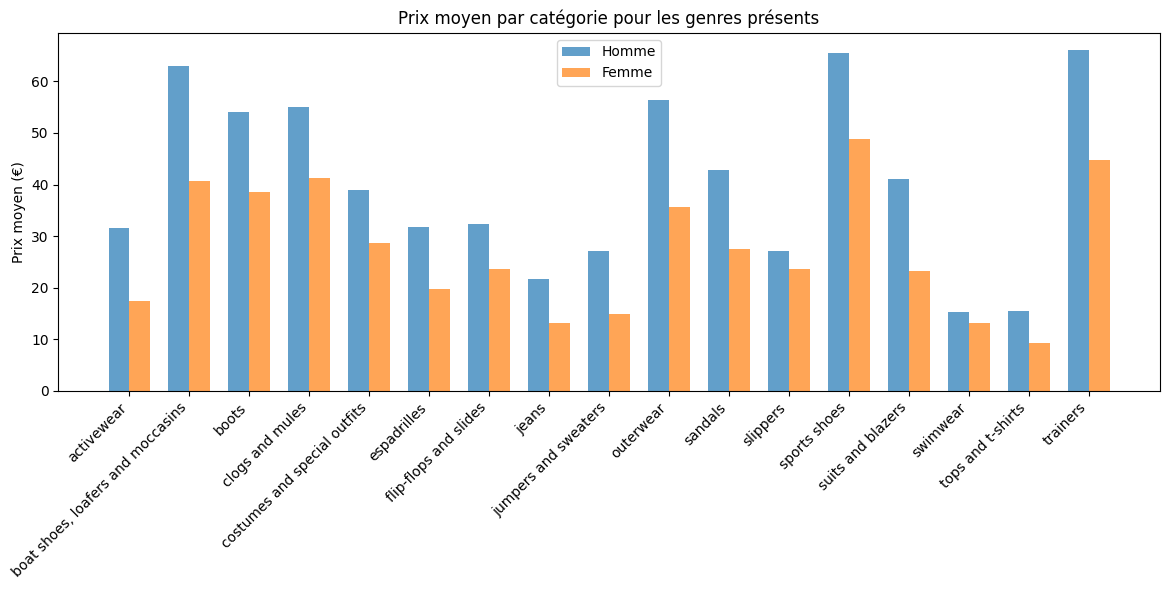

In [22]:
all_data = []

with open('vinted_products_api.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        item = json.loads(line)

        # Vérifier devise EUR
        if item.get('prix', {}).get('currency_code') != 'EUR':
            continue

        query = str(item.get('query'))  # important : str
        if query not in gender_dict:
            continue  # ignore articles dont le genre n'est pas défini

        all_data.append({
            'price': float(item['prix']['amount']),
            'gender': gender_dict[query],
            'category': category_dict.get(query, 'Unknown'),
            'country': item.get('country', 'unknown')
        })

# Créer le DataFrame
df_full = pd.DataFrame(all_data)
print(df_full.head())

# 1. Moyenne par catégorie et genre
df_grouped = df_full.groupby(['category', 'gender'])['price'].mean().reset_index()

# 2. Catégories communes
categories_homme = set(df_grouped[df_grouped['gender']=='homme']['category'])
categories_femme = set(df_grouped[df_grouped['gender']=='femme']['category'])
common_categories = categories_homme & categories_femme

# 3. Filtrer
df_common = df_grouped[df_grouped['category'].isin(common_categories)]

categories = df_common['category'].unique()
x = np.arange(len(categories))
width = 0.35

prices_h = df_common[df_common['gender']=='homme'].set_index('category').loc[categories]['price']
prices_f = df_common[df_common['gender']=='femme'].set_index('category').loc[categories]['price']

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, prices_h, width, label='Homme', alpha=0.7)
ax.bar(x + width/2, prices_f, width, label='Femme', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_ylabel('Prix moyen (€)')
ax.set_title('Prix moyen par catégorie pour les genres présents')
ax.legend()
plt.tight_layout()
plt.show()